In [ ]:
import polars as pl
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn

In [ ]:
dlp = pl.read_csv("drive/MyDrive/result/unificated.ndjson_structured.csv")

In [ ]:
dlp.head(2)

In [ ]:
dlp.filter(pl.col("EventId").is_null())

In [ ]:
dlp.select(pl.col("LineId", "EventId"))

In [ ]:
dlp_np = dlp.select(pl.col("LineId", "EventId")).to_numpy()
dlp_np

In [ ]:
ord_dict = dlp.select(pl.col("EventId")).unique().to_numpy()
ord_dict.shape

In [ ]:
new_df_support_array = []

for index, elem in enumerate(ord_dict):
  new_df_support_array.append((index+1, elem.item()))

token_mapping = pl.DataFrame(new_df_support_array)
token_mapping = token_mapping.rename({
    "column_0": "value",
    "column_1": "EventId"
})

token_mapping

In [ ]:
token_mapping.write_csv("drive/MyDrive/result/token_mapping.csv")

In [ ]:
del new_df_support_array
del dlp_np

In [ ]:
token_mapping = pl.read_csv("drive/MyDrive/result/token_mapping.csv")

In [ ]:
dlp = dlp.select(pl.col("LineId", "EventId")).join(token_mapping, on="EventId")
dlp

LineId,EventId,value
i64,str,i64
1,"""727cfaa5""",988
2,"""b64554f3""",792
3,"""441857d8""",369
4,"""830d71fb""",775
5,"""9cbef795""",100
6,"""727cfaa5""",988
7,"""57cea39a""",594
8,"""727cfaa5""",988
9,"""727cfaa5""",988


In [ ]:
sw = 7

for i in range(1, sw+1):
  dlp = dlp.with_columns(
      pl.Series(dlp["value"]).shift(i).alias(f"t-{i}")
  )
dlp = dlp.drop_nulls().select(pl.col("*").exclude("EventId"))
dlp

LineId,value,t-1,t-2,t-3,t-4,t-5,t-6,t-7
i64,i64,i64,i64,i64,i64,i64,i64,i64
8,988,594,988,100,775,369,792,988
9,988,988,594,988,100,775,369,792
10,792,988,988,594,988,100,775,369
11,1040,792,988,988,594,988,100,775
12,775,1040,792,988,988,594,988,100
13,988,775,1040,792,988,988,594,988
14,594,988,775,1040,792,988,988,594
15,594,594,988,775,1040,792,988,988
16,792,594,594,988,775,1040,792,988


<Axes: xlabel='LineId', ylabel='value'>

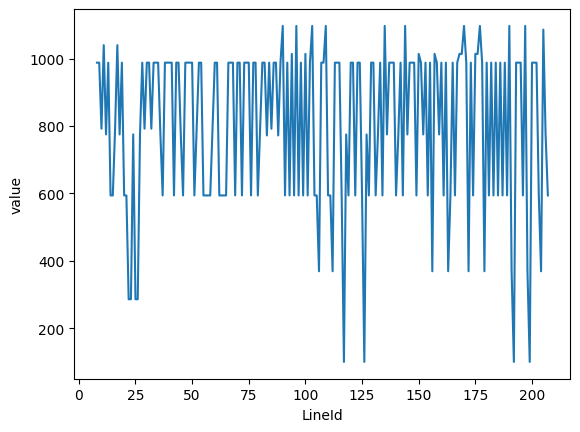

In [ ]:
sns.lineplot(data=dlp[:200].to_pandas(), y="value", x="LineId")

In [ ]:
shifted_np = dlp.to_numpy()
shifted_np

array([[      8,     988,     594, ...,     369,     792,     988],
       [      9,     988,     988, ...,     775,     369,     792],
       [     10,     792,     988, ...,     100,     775,     369],
       ...,
       [1939205,     988,     100, ...,     988,     988,     594],
       [1939206,     594,     988, ...,     792,     988,     988],
       [1939207,     988,     594, ...,     369,     792,     988]])

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))
shifted_np = scaler.fit_transform(shifted_np)

shifted_np

array([[-1.        ,  0.69151671,  0.01628106, ..., -0.36932305,
         0.35561268,  0.69151671],
       [-0.99999897,  0.69151671,  0.69151671, ...,  0.32647815,
        -0.36932305,  0.35561268],
       [-0.99999794,  0.35561268,  0.69151671, ..., -0.83033419,
         0.32647815, -0.36932305],
       ...,
       [ 0.99999794,  0.69151671, -0.83033419, ...,  0.69151671,
         0.69151671,  0.01628106],
       [ 0.99999897,  0.01628106,  0.69151671, ...,  0.35561268,
         0.69151671,  0.69151671],
       [ 1.        ,  0.69151671,  0.01628106, ..., -0.36932305,
         0.35561268,  0.69151671]])

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [ ]:
X = shifted_np[:, 2:]
y = shifted_np[:, 1]

X.shape, y.shape

((1939200, 7), (1939200,))

In [ ]:
from copy import deepcopy as dc

X = dc(np.flip(X, axis=1))
X

array([[ 0.69151671,  0.35561268, -0.36932305, ..., -0.83033419,
         0.69151671,  0.01628106],
       [ 0.35561268, -0.36932305,  0.32647815, ...,  0.69151671,
         0.01628106,  0.69151671],
       [-0.36932305,  0.32647815, -0.83033419, ...,  0.01628106,
         0.69151671,  0.69151671],
       ...,
       [ 0.01628106,  0.69151671,  0.69151671, ..., -0.36932305,
         0.32647815, -0.83033419],
       [ 0.69151671,  0.69151671,  0.35561268, ...,  0.32647815,
        -0.83033419,  0.69151671],
       [ 0.69151671,  0.35561268, -0.36932305, ..., -0.83033419,
         0.69151671,  0.01628106]])

In [ ]:
where_to_split = 0.90

split_index = int(len(X)*where_to_split)
split_index

1745280

In [ ]:
X_train = X[:split_index]
X_test = X[split_index:]

y_train = y[:split_index]
y_test = y[split_index:]

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1745280, 7), (193920, 7), (1745280,), (193920,))

In [ ]:
X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()

X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).float()


X_train.shape, y_train.shape, X_test.shape, y_test.shape

(torch.Size([1745280, 7]),
 torch.Size([1745280]),
 torch.Size([193920, 7]),
 torch.Size([193920]))

In [ ]:
X_train = X_train.reshape((-1, sw, 1))
X_test = X_test.reshape((-1, sw, 1))

y_train = y_train.reshape((-1, 1))
y_test = y_test.reshape((-1, 1))
X_train.shape, X_test.shape, y_train.shape, y_test.shape # see if they match up, here

(torch.Size([1745280, 7, 1]),
 torch.Size([193920, 7, 1]),
 torch.Size([1745280, 1]),
 torch.Size([193920, 1]))

In [ ]:
from torch.utils.data import Dataset

class FlawsLogDataset(Dataset):
  def __init__(self, X, y):
    self.X = X
    self.y = y

  def __len__(self):
    return len(self.X)

  def __getitem__(self, i):
    return self.X[i], self.y[i]


In [ ]:
train_dataset = FlawsLogDataset(X_train, y_train)
test_dataset = FlawsLogDataset(X_test, y_test)

In [ ]:
from torch.utils.data import DataLoader

batch_size = 2048

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
for _, batch in enumerate(train_loader):
  x_batch, y_batch = batch[0].to(device), batch[1].to(device)
  print(x_batch.shape, y_batch.shape)
  break

torch.Size([2048, 7, 1]) torch.Size([2048, 1])


In [ ]:
class LSTM(nn.Module):
  def __init__(self, input_size, hidden_size, num_stacked_layers):
    super().__init__()

    self.hidden_size = hidden_size
    self.num_stacked_layers = num_stacked_layers

    self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers, batch_first=True)
    self.fc = nn.Linear(hidden_size, 1)

  def forward(self, x):
    batch_size = x.size(0)
    h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
    c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)

    out, _ = self.lstm(x, (h0, c0))
    out = self.fc(out[:, 1, :])
    return out

model = LSTM(1, 64, 2)
model.to(device)
model

LSTM(
  (lstm): LSTM(1, 64, num_layers=2, batch_first=True)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

In [ ]:
def train_one_epoch():
  model.train(True)
  print(f"Epoch: {epoch+1}")
  running_loss = 0.0

  for batch_index, batch in enumerate(train_loader):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)

    output = model(x_batch)
    loss = loss_function(output, y_batch)
    running_loss += loss.item()

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if batch_index % 100 == 99:
      avg_loss_across_batches = running_loss/100
      print("Batch {0}, Loss {1:.5f}".format(
          batch_index+1,
          avg_loss_across_batches
      ))
      running_loss = 0.0

In [ ]:
def validate_one_epoch():
  model.train(False)
  running_loss = 0.0

  for batch_index in enumerate(test_loader):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)

    with torch.no_grad():
      output = model(x_batch)
      loss = loss_function(output, y_batch)
      running_loss += loss.item()

    avg_loss_across_batches = running_loss / len(test_loader)

  print("Val Loss: {0:.3f}".format(avg_loss_across_batches))
  print('***************************************************')

In [ ]:
learning_rate = 1e-3
num_epochs = 5

loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
  train_one_epoch()
  validate_one_epoch()

KeyboardInterrupt: 

In [ ]:
torch.save(model, "currently_trained.pth")

In [ ]:
model = torch.load("currently_trained.pth")

In [ ]:
to_get = 2048

with torch.no_grad():
    predicted = model(X_train[:to_get]).to(device).to('cpu').numpy()

plt.plot(y_train[to_get], label='Real Log Template')
plt.plot(predicted, label='Predicted Log Template')
plt.xlabel('Time')
plt.ylabel('Log Template')
plt.legend()
plt.show()